#Data Science methods V.Ger Travel

This Notebook will help you generate synthetic datasets for Time Series. Instructions for setting parameters can be found at the end of the Notebook.
##The generated Time Series are plotted and saved in a .csv file. After generation the Notebook provides a decomposition of the Time series. It is up to you to find the correct set of parameters based on the instructions provided and through inspecting the code below.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-36251584.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)


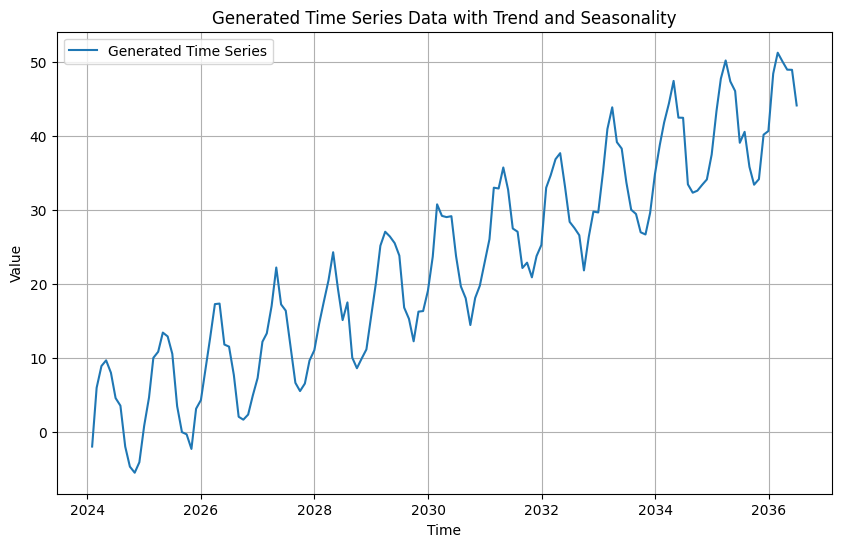

Time series data saved to 't_s.csv'.


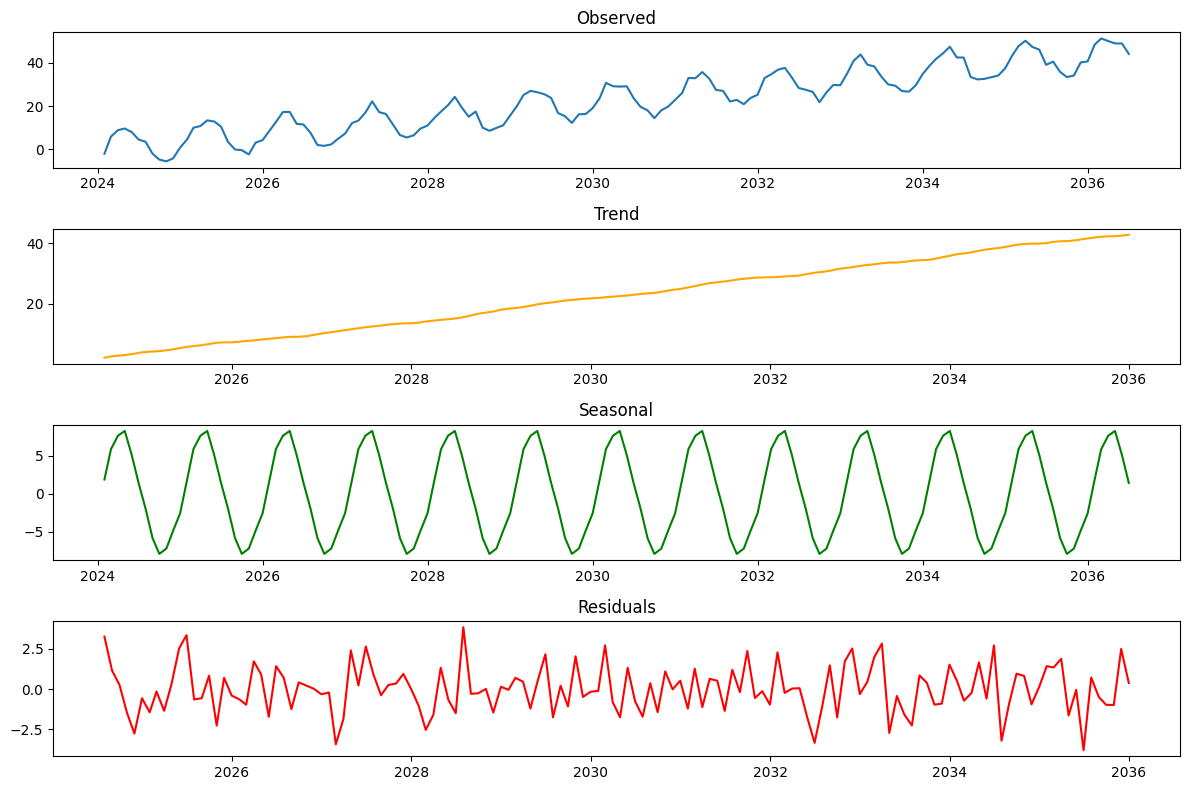

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from google.colab import drive
drive.mount('/content/drive')

def generate_time_series(n_periods=100, frequency='days', trend_slope=0.3, seasonal_period='monthly', seasonal_amplitude=5, noise_level=0.5):
    # Set frequency based on the input (days, months, or weeks)
    if frequency == 'days':
        freq = 'D'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    elif frequency == 'months':
        freq = 'M'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    elif frequency == 'weeks':
        freq = 'W'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    else:
        raise ValueError("Frequency should be 'days', 'months', or 'weeks'.")

    # 1. Create a linear trend: A simple increasing trend from 0 to trend_slope * n_periods
    trend = np.linspace(0, trend_slope * n_periods, n_periods)  # Linear trend

    # 2. Add seasonality based on the chosen period (weekly, monthly, or annual)
    seasonal_component = np.zeros(n_periods)
    if seasonal_period == 'monthly':
        # One full cycle per year (12 months)
        seasonal_frequency = 2 * np.pi / 12  # For monthly frequency
    elif seasonal_period == 'weekly':
        # One full cycle per year (52 weeks)
        seasonal_frequency = 2 * np.pi / 52  # For weekly frequency
    elif seasonal_period == 'annual':
        # One full cycle per year (365 days)
        seasonal_frequency = 2 * np.pi / 365  # For annual frequency
    else:
        raise ValueError("Seasonal period should be 'monthly', 'weekly', or 'annual'.")

    # Smooth seasonal component (sine wave with the defined frequency)
    seasonal_component = seasonal_amplitude * np.sin(np.linspace(0, seasonal_frequency * n_periods, n_periods))

    # 3. Add minimal noise to the time series to make the residuals more realistic
    noise = np.random.normal(0, noise_level, n_periods)

    # 4. Combine the trend and seasonality
    time_series = trend + seasonal_component + noise

    # Prepare data for CSV output
    data = {'Time': time_index[:len(time_series)], 'Value': time_series}
    t_s = pd.DataFrame(data)

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(t_s['Time'], t_s['Value'], label='Generated Time Series')
    plt.title('Generated Time Series Data with Trend and Seasonality')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Save to CSV
    #df.to_csv('generated_time_series.csv', index=False)

    t_s.to_csv('/content/drive/My Drive/t_s.csv', index=False)

    print("Time series data saved to 't_s.csv'.")

    return t_s

#
def decompose_time_series(t_s, frequency='D'):
    # Ensure the 'Time' column is in datetime format
    t_s['Time'] = pd.to_datetime(t_s['Time'])

    # Set 'Time' as the index
    t_s.set_index('Time', inplace=True)

    # Perform decomposition
    decomposition = seasonal_decompose(t_s['Value'], model='additive', period=365 if frequency == 'days' else 12)

    # Plot the decomposed components
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.title('Observed')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.title('Seasonal')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='red')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()

# Example usage of the function
t_s = generate_time_series(n_periods=150, frequency='months', trend_slope=0.3, seasonal_period='monthly', seasonal_amplitude=8, noise_level=1.5)

decompose_time_series(t_s)



1. n_periods (Number of Time Steps)

    Description: Specifies how many data points you want to generate.
    Usage: Affects the length of the time series.
    Example Values:
        n_periods=100 for a short time series.
        n_periods=500 for a longer time series.
    Default: 100.

2. frequency (Time Frequency)

    Description: Defines the time intervals of the series.
    Options:
        'days': Daily time intervals.
        'weeks': Weekly time intervals.
        'months': Monthly time intervals.
    Usage: Determines the time range of the time series.
    Example Values:
        frequency='days' for daily observations.
        frequency='weeks' for weekly data.
        frequency='months' for monthly data.
    Default: 'days'.

3. trend_slope (Linear Trend Slope)

    Description: Controls how quickly the trend increases over time.
    Usage: Affects the magnitude of the overall increase in the series.
    Example Values:
        trend_slope=0.1: A slow-growing trend.
        trend_slope=0.5: A faster-growing trend.
        trend_slope=0: No trend (flat).
    Default: 0.3.

4. seasonal_period (Seasonal Pattern)

    Description: Specifies the type of seasonality to include in the series.
    Options:
        'monthly': Seasonal variations occur every 12 periods (e.g., months in a year).
        'weekly': Seasonal variations occur every 52 periods (e.g., weeks in a year).
        'annual': Seasonal variations occur every 365 periods (e.g., days in a year).
    Usage: Adjust this to reflect real-world seasonality based on the data's frequency.
    Example Values:
        seasonal_period='monthly' for sales data.
        seasonal_period='weekly' for weekly activity patterns.
        seasonal_period='annual' for long-term trends.
    Default: 'monthly'.

5. seasonal_amplitude (Strength of Seasonality)

    Description: Controls the magnitude of the seasonal fluctuations.
    Usage: Sets the "height" of seasonal oscillations relative to the trend.
    Example Values:
        seasonal_amplitude=2: Subtle seasonal variation.
        seasonal_amplitude=10: Strong seasonal variation.
    Default: 5.

6. noise_level (Random Variation)

    Description: Adds random noise to simulate natural variability in the data.
    Usage: Higher values create noisier data, while lower values make it smoother.
    Example Values:
        noise_level=0: No noise.
        noise_level=0.5: Moderate noise.
        noise_level=2: High noise.
    Default: 0.5.

Tips for Setting Parameters:

    Match Seasonality to Frequency: Ensure that the seasonal_period makes sense for the chosen frequency.
        Example: For frequency='months', use seasonal_period='monthly' for realistic results.
    Control Noise for Clarity: Use noise_level=0 for clean series or increase it slightly (e.g., 0.2) to simulate real-world randomness.
    Trend Dominance: Ensure the trend_slope is much larger than seasonal_amplitude if you want the trend to dominate over seasonality.